In [0]:
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 94 (delta 45), reused 59 (delta 22), pack-reused 0
Unpacking objects: 100% (94/94), done.


Using TensorFlow backend.


170500096/170498071 [==============================] - 31s 0us/step
50000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
1822498
8257012
Train on 47500 samples, validate on 2500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
47500/47500 [==============================] - 44s 931us/sample - loss: 2.2619 - acc: 0.2861 - val_loss: 2.3122 - val_acc: 0.0932
Epoch 2/50
47500/47500 [==============================] - 25s 535us/sample - loss: 1.7275 - acc: 0.4056 - val_loss: 2.3479 - val_acc: 0.0876
Epoch 3/50
47500/47500 [==============================] - 25s 516us/sample - loss: 1.5032 - acc: 0.4709 - val_loss: 2.3688 - val_acc: 0.1728
Epoch 4/50
47500/47500 [==============================] - 24s 510us/sample - loss: 1.3686 - acc: 0.5188 - val_loss: 1.5732 - val_acc: 0.4336
Epoch 5/50
47500/47500 [==============================] - 25s 529us/sample - loss: 1.2465 - acc: 0.5

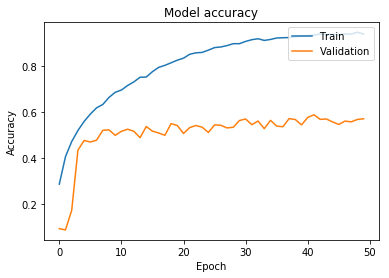

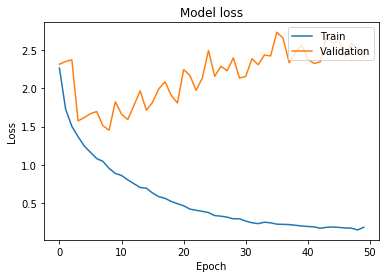

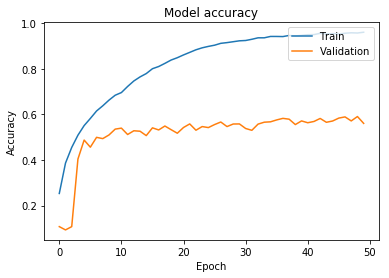

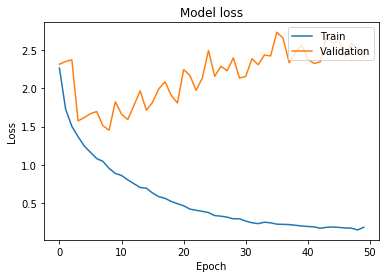

256_50_shuffle_Test loss: 2.590379862785339
256_50_shuffle_Test accuracy: 0.5659
256_50_mobile_Test loss: 2.4222202590942383
256_50_mobile_Test accuracy: 0.5504


In [1]:

!git clone https://github.com/SirPounce/models

from models.utils import load_data, plot_accuracy, plot_loss, get_flops
from models.shuffle_unit import ShuffleNet
from models.mobilenet import MobileNet

import numpy as np

import matplotlib.pyplot as plt


from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

import h5py



sb = []




########################################################################
##                        load and split
########################################################################

train_data, test_data = load_data()
x_train, y_train = train_data

k = 0.95
# x_train = x_train[0:1000, :, :, :]
# y_train = y_train[0:1000, :]
n = np.shape(x_train)[0]
print(n)
x_train, x_val = [x_train[0:int(k*n), :, :, :], x_train[int(k*n):, :, :, :]]
y_train, y_val = [y_train[0:int(k*n), :], y_train[int(k*n):, :]]
x_test, y_test = test_data

sb.append(f'loaded data\n with shapes x_train: {np.shape(x_train)} and y_train: {np.shape(y_train)}\n')



#########################################################################
##                        HYPERPARAMETERS
#########################################################################
## batch_size, n_epochs, learning_rate

parameters = [
    #(128, 60, 0.001, 0.00000001),
    #(128, 60, 0.0008, 0.00001),
    #(128, 80, 0.005),
    #(256, 80, 0.005)
    (256, 50, 0.001)
]





#########################################################################
##                INIT MODELS AND PRINT COMPLEXITY
#########################################################################

shuffle_net = ShuffleNet(
        # input_shape,
        np.shape(x_train[0]),
        # nb_classes,
        np.squeeze(np.shape((y_train[0]))),
        include_top=True,
        weights=None,
        nb_groups=8     # can vary from 1 2 3 4 8
)
print(get_flops(shuffle_net))
sb.append(f'flops ShuffleNet: {get_flops(shuffle_net)}\n')

mobile_net = MobileNet(
        np.shape(x_train[0]),
        np.squeeze(np.shape((y_train[0]))),
)
print(get_flops(mobile_net))
sb.append(f'flops ShuffleNet: {get_flops(mobile_net)}\n')



##########################################################################



for param in parameters:
  batch_size, n_epochs, learning_rate = param
  

  shuffle_net = ShuffleNet(
        # input_shape,
        np.shape(x_train[0]),
        # nb_classes,
        np.squeeze(np.shape((y_train[0]))),
        include_top=True,
        weights=None,
        nb_groups=8     # can vary from 1 2 3 4 8
  )
  shuffle_net.compile(
        loss=categorical_crossentropy,
        optimizer=Adam(lr=learning_rate),
        metrics=['accuracy']
  )
  shuffle = shuffle_net.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=n_epochs,
        verbose=1,
        validation_data=(x_val, y_val)
  )
  mobile_net = MobileNet(
        np.shape(x_train[0]),
        np.squeeze(np.shape((y_train[0]))),
  )
  
  mobile_net.compile(
        loss=categorical_crossentropy,
        optimizer=Adam(lr=learning_rate),
        metrics=['accuracy']
  )
  mobile = mobile_net.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=n_epochs,
        verbose=1,
        validation_data=(x_val, y_val)
  )


  f = plot_accuracy(shuffle.history)
  plt.show()
  f.savefig(f'{param[0]}_{param[1]}_shuffle_accuracy.pdf', bbox_inches='tight')
  f = plot_loss(shuffle.history)
  plt.show()
  f.savefig(f'{param[0]}_{param[1]}_shuffle_loss.pdf', bbox_inches='tight')
  
  f = plot_accuracy(mobile.history)
  plt.show()
  f.savefig(f'{param[0]}_{param[1]}_mobile_accuracy.pdf', bbox_inches='tight')
  f = plot_loss(shuffle.history)
  plt.show()
  f.savefig(f'{param[0]}_{param[1]}_mobile_loss.pdf', bbox_inches='tight')
  
  score = shuffle_net.evaluate(x_test, y_test, verbose=0)
  print(f'{param[0]}_{param[1]}_shuffle_Test loss:', score[0])
  print(f'{param[0]}_{param[1]}_shuffle_Test accuracy:', score[1])
  score = mobile_net.evaluate(x_test, y_test, verbose=0)
  print(f'{param[0]}_{param[1]}_mobile_Test loss:', score[0])
  print(f'{param[0]}_{param[1]}_mobile_Test accuracy:', score[1])
          
  score = shuffle_net.evaluate(x_test, y_test, verbose=0)

  sb.append(f'{param[0]}_{param[1]}_shuffle_Test loss:, {score[0]}\n')
  sb.append(f'{param[0]}_{param[1]}_shuffle_Test accuracy:, {score[1]}\n')
  score = mobile_net.evaluate(x_test, y_test, verbose=0)
  sb.append(f'{param[0]}_{param[1]}_mobile_Test loss:, {score[0]}\n')
  sb.append(f'{param[0]}_{param[1]}_mobile_Test accuracy:, {score[1]}\n')
          
  with open(f'{param[0]}_{param[1]}_results.txt', 'w') as f:
    f.write(''.join(sb))
  shuffle_net.save_weights(f'{param[0]}_{param[1]}_shuffle.h5')
  mobile_net.save_weights(f'{param[0]}_{param[1]}_mobile.h5')

          
  

